In [54]:
import numpy 
import math 
from scipy import integrate
from matplotlib import pyplot 

In [55]:
# defines the cylinder
R = 1.0                                                           # radius
theta = numpy.linspace(0, 2*math.pi, 100)                         # angles in radians
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)   # coordinates of the cylinder


%matplotlib inline

In [56]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.sigma = 1                             # source strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficient

In [57]:
def get_source_panel_velocity(p,x,y):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  math.sin(p.beta)*(x-p.xb) - math.cos(p.beta)*(y-p.yb)
    y_p =  math.cos(p.beta)*(x-p.xb) + math.sin(p.beta)*(y-p.yb)
    
    u_p = p.sigma/(4*math.pi)*numpy.log((x_p**2+y_p**2)/((x_p-p.length)**2+y_p**2))
    v_p = p.sigma/(2*math.pi)*(numpy.arctan2(y_p,x_p-p.length) - numpy.arctan2(y_p,x_p))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

In [58]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/u_inf)**2

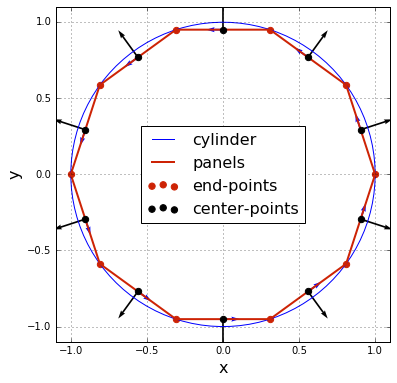

In [59]:
N_panels = 10                # number of panels desired

# defining the end-points of the panels
x_ends = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

# defining the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plotting the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=10, width=0.005)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.t[0] for p in panels], [p.t[1] for p in panels],
              scale=20, width=0.005, color='b')
pyplot.legend(['cylinder', 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [60]:
u_inf =1

In [61]:
A = numpy.empty((N_panels, N_panels), dtype=float)
#numpy.fill_diagonal(A, 0.5)
    
for i in range(N_panels):
    for j in range(N_panels):
        if i != j:
            A[i,j] = numpy.dot(get_source_panel_velocity(panels[j],panels[i].xc,panels[i].yc),panels[i].n)
        else:
            A[i,j] = 0.5
            
#b = - u_inf * numpy.sin([panel.beta for panel in panels])
b = numpy.empty((N_panels), dtype='float')
for i in range(N_panels):
    b[i] = -numpy.dot(numpy.array([u_inf,0]), (panels[i].n))
sigma = numpy.linalg.solve(A,b)   
C = numpy.empty((N_panels, N_panels), dtype=float)
for i in range(N_panels):
    for j in range(N_panels):
        if i != j:
            C[i,j] = numpy.dot(get_source_panel_velocity(panels[j],panels[i].xc,panels[i].yc),panels[i].t)
        else:
            C[i,j] = 0.0

d = numpy.empty((N_panels), dtype='float')
for i in range(N_panels):
    d[i] = numpy.dot(numpy.array([u_inf,0]), (panels[i].t))

In [62]:
vt = numpy.dot(C,sigma) + d
print(sigma)
for i, panel in enumerate(panels):
    panel.vt = vt[i]
    
for panel in panels:
    panel.cp = 1.0 - (panel.vt)**2

[ -2.17594204e+00  -1.34480614e+00  -1.07242296e-15   1.34480614e+00
   2.17594204e+00   2.17594204e+00   1.34480614e+00   4.35659510e-17
  -1.34480614e+00  -2.17594204e+00]


In [63]:
cp_anal = 1.0 - 4.0*(y_cylinder/R)**2

# calculates the accuracy
accuracy = numpy.sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths:', accuracy)

--> sum of source/sink strengths: 6.1803398875


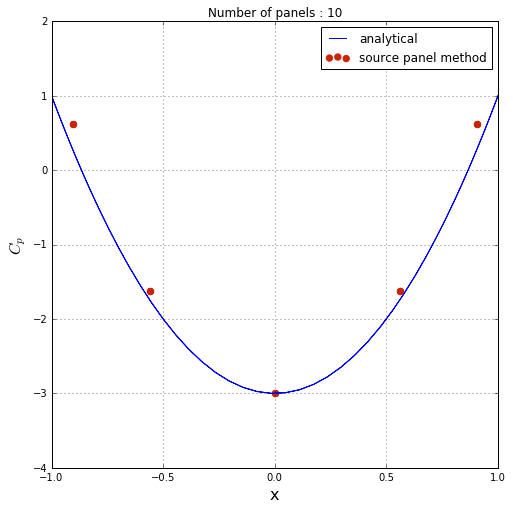

In [64]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16);
pyplot.ylabel('$ C_p$', fontsize=16);
pyplot.title('Number of panels : %d' % N_panels);
pyplot.plot(x_cylinder,cp_anal)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],color='#CD2305', s=40, zorder=2)
pyplot.legend(['analytical', 'source panel method'])
pyplot.xlim(-1,1)
pyplot.ylim(-4,2);

(-0.4, 0.4)

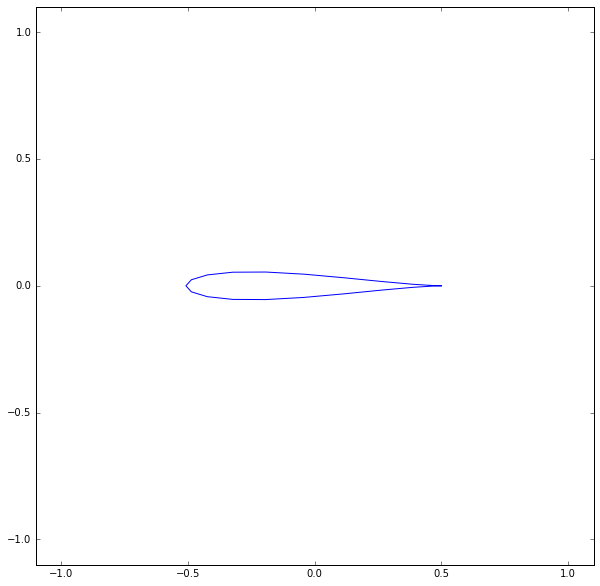

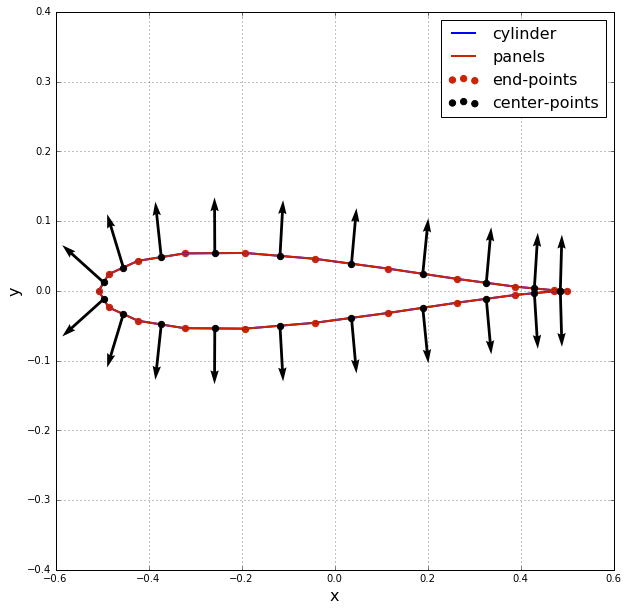

In [65]:
N_panels = 20
c=1
H =0
a=.25
T=.12

r = (0.25 +T/(3*math.sqrt(3)))
theta = (numpy.linspace(0,2*math.pi,N_panels+1))
R,THETA= numpy.meshgrid(r,theta)
zeta = R*numpy.exp(1j*THETA)


zeta_c = -4*a/(3*math.sqrt(3))*T + 1j*2*a*H
Z1airfoil = (zeta+zeta_c) + a**2 /(zeta+zeta_c)
pyplot.figure(2)
pyplot.figure(figsize=(10,10))
pyplot.plot(Z1airfoil.real,Z1airfoil.imag)
pyplot.xlim(-1.1,1.1)
pyplot.ylim(-1.1,1.1);


# defining the end-points of the panels
x_ends = Z1airfoil.real[:,0]
y_ends = Z1airfoil.imag[:,0]

# defining the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
   

size = 10
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)

pyplot.plot(Z1airfoil.real, Z1airfoil.imag, color='b', linestyle='-', linewidth=2)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=10, width=0.005)
pyplot.legend(['cylinder', 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
pyplot.xlim(-.6, .6)
pyplot.ylim(-.4, .4);

#print([p.xa for p in panels],[p.ya for p in panels])

In [66]:
u_inf =1
A = numpy.empty((N_panels, N_panels), dtype=float)
#numpy.fill_diagonal(A, 0.5)
    
for i in range(N_panels):
    for j in range(N_panels):
        if i != j:
            A[i,j] = numpy.dot(get_source_panel_velocity(panels[j],panels[i].xc,panels[i].yc),panels[i].n)
        else:
            A[i,j] = 0.5
            
#b = - u_inf * numpy.sin([panel.beta for panel in panels])
b = numpy.empty((N_panels), dtype='float')
for i in range(N_panels):
    b[i] = -numpy.dot(numpy.array([u_inf,0]), (panels[i].n))
sigma = numpy.linalg.solve(A,b)   
C = numpy.empty((N_panels, N_panels), dtype=float)

for i in range(N_panels):
    for j in range(N_panels):
        if i != j:
            C[i,j] = numpy.dot(get_source_panel_velocity(panels[j],panels[i].xc,panels[i].yc),panels[i].t)
        else:
            C[i,j] = 0.0
            
d = numpy.empty((N_panels), dtype='float')
for i in range(N_panels):
    d[i] = numpy.dot(numpy.array([u_inf,0]), (panels[i].t))


In [67]:
# computes the tangential velocity at each panel center-point
vt = numpy.dot(C,sigma) + d
print(sigma)
for i, panel in enumerate(panels):
    panel.vt = vt[i]
    

[-0.02625414 -0.05951229 -0.09018285 -0.10964029 -0.10969989 -0.08092882
 -0.01280446  0.11255996  0.35533052  1.07562439  1.07562439  0.35533052
  0.11255996 -0.01280446 -0.08092882 -0.10969989 -0.10964029 -0.09018285
 -0.05951229 -0.02625414]


In [68]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, u_inf)

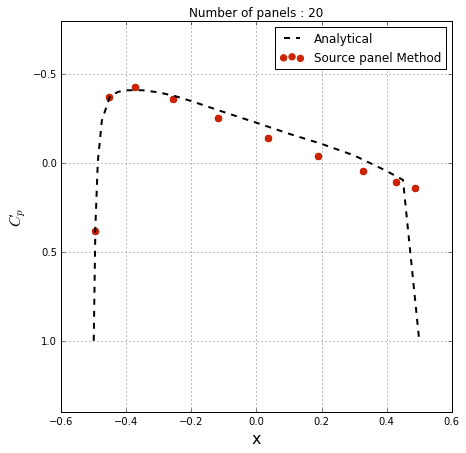

In [69]:
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100
xtheo -=0.5

pyplot.figure(figsize=(7,7))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16);
pyplot.ylabel(r'$ C_p$', fontsize=16);
pyplot.title('Number of panels : %d' % N_panels);
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],color='#CD2305', s=40, zorder=2)
pyplot.plot(xtheo,1-voverVsquared, color='k', linestyle='--',linewidth=2)
pyplot.xlim(-.6, .6)
pyplot.ylim(1.4, -.8);
pyplot.legend(['Analytical','Source panel Method'])